In [ ]:
import pinocchio as pin

In [ ]:
dir(pin)

In [ ]:
import os
from Go2Py import ASSETS_PATH
urdf_path = os.path.join(ASSETS_PATH, 'urdf/go2.urdf')
urdf_root_path = os.path.join(ASSETS_PATH, 'urdf')

In [ ]:
robot = pin.RobotWrapper.BuildFromURDF(urdf_path, urdf_root_path, pin.JointModelFreeFlyer())

In [ ]:
robot_model = robot.model
robot_data = robot.data

In [ ]:
robot_mass = sum([I.mass for I in robot_model.inertias])
base_frame_name = robot_model.frames[2].name

In [ ]:
for frame in robot.model.frames:
    print(frame.name)

In [ ]:
for name in robot.model.names:
    print(name)

In [ ]:
robot_model.getJointId("RR_calf_joint")

In [ ]:
unitree_joints = [
    'FR_hip_joint',
    'FR_thigh_joint',
    'FR_calf_joint',
    'FL_hip_joint',
    'FL_thigh_joint',
    'FL_calf_joint',
    'RR_hip_joint',
    'RR_thigh_joint',
    'RR_calf_joint',
    'RL_hip_joint',
    'RL_thigh_joint',
    'RL_calf_joint',
    ]
pin_joints = [name for name in robot.model.names[2:]]

In [ ]:
pin_unitree_id_translator = [robot.model.getJointId(joint_name) for joint_name in unitree_joints]

In [ ]:
pin_unitree_id_translator

In [3]:
import os
from Go2Py import ASSETS_PATH
import pinocchio as pin
import numpy as np
urdf_path = os.path.join(ASSETS_PATH, 'urdf/go2.urdf')
urdf_root_path = os.path.join(ASSETS_PATH, 'urdf')


class Go2Model:
    def __init__(self):
        self.robot = pin.RobotWrapper.BuildFromURDF(urdf_path, urdf_root_path, pin.JointModelFreeFlyer())
        # Standing joint configuration in Unitree Joint order
        self.ef_frames = ['FR_foot', 'FL_foot', 'RR_foot', 'RL_foot']
        self.dq_reordering_idx = np.array([0, 1, 2, 3, 4, 5,\
                                           9, 10, 11, 6, 7, 8, 15, 16, 17, 12, 13, 14])
        self.q_reordering_idx = np.array([9, 10, 11, 6, 7, 8, 15, 16, 17, 12, 13, 14])-6
        self.ef_J_ = {}
        
    def update(self, q, dq, T, v):
        q_ = np.hstack([pin.SE3ToXYZQUATtuple(pin.SE3(T)), q[self.q_reordering_idx]])
        dq_ = np.hstack([v, dq[self.q_reordering_idx]])
        self.robot.computeJointJacobians(q_)
        self.robot.framesForwardKinematics(q_)
        self.robot.centroidalMomentum(q_,dq_)
        self.nle_ = self.robot.nle(q_, dq_)[self.dq_reordering_idx]
        self.g_ = self.robot.gravity(q_)[self.dq_reordering_idx]
        self.M_ = self.robot.mass(q_)[[self.dq_reordering_idx],[self.dq_reordering_idx]]
        self.Minv_ = pin.computeMinverse(self.robot.model, self.robot.data, q_)[[self.dq_reordering_idx],[self.dq_reordering_idx]]
        for ef_frame in self.ef_frames:
            J = self.robot.getFrameJacobian(self.robot.model.getFrameId(ef_frame), pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
            self.ef_J_[ef_frame]=J[:, self.dq_reordering_idx]

    def getInfo(self):
        return {
            'M':self.M_,
            'Minv':self.Minv_,
            'nle':self.nle_,
            'g':self.g_,
            'J':self.ef_J_,
        }

In [4]:
model = Go2Model()

In [5]:
model.update(np.zeros(12), np.zeros(12), np.eye(4), np.zeros(6))

In [8]:
from Go2Py.sim.mujoco import Go2Sim
robot = Go2Sim()

In [11]:
robot.step()
mujoco_params = robot.getDynamicsParams()

In [67]:
states = robot.getJointStates()
q = states['q']
dq = states['dq']
trans, quat = robot.getPose()
quat = np.hstack([quat[1:], quat[0]])
q = np.hstack([trans, quat, q])

In [102]:
dq_reordering_idx = np.array([0, 1, 2, 3, 4, 5,\
                                           9, 10, 11, 6, 7, 8, 15, 16, 17, 12, 13, 14])

In [125]:
M1 = model.robot.mass(q)[dq_reordering_idx,:]
M1=M1[:,dq_reordering_idx]
# M2 = robot.getDynamicsParams()['M']
(M1-M2).sum()
# M1.shape

-0.5194361885075903

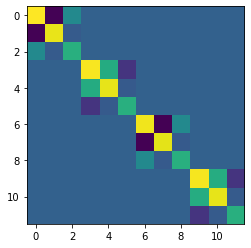

In [126]:
import matplotlib.pyplot as plt
plt.imshow(M1[6:,6:])

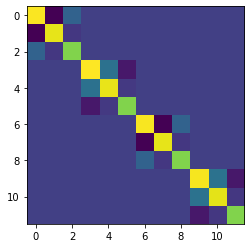

In [117]:
plt.imshow(M2[6:,6:])

In [129]:
robot.model.body_mass.sum()

15.206408000000003

In [135]:
s = model.robot.model
sum([i.mass for i in s.inertias])

15.019000000000004

In [97]:
Jp, Jr = robot.getSiteJacobian('FL_foot')
model.robot.computeJointJacobians(q).T
J = model.robot.getFrameJacobian(model.robot.model.getFrameId('FL_foot'), pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)

In [143]:
(Jp.T-J[0:3,:].T).sum(),(Jr.T-J[3:,:].T).sum()

(0.009002122197148882, 0.13167880433018087)

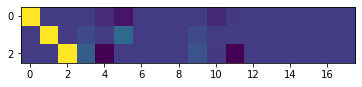

In [136]:
plt.imshow(Jp)

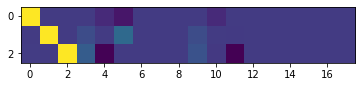

In [138]:
plt.imshow(J[0:3,dq_reordering_idx])

In [ ]:
q = np.hstack([pin.SE3ToXYZQUATtuple(pin.SE3(np.eye(4))), np.zeros(12)])
v = np.zeros(18)
robot.computeJointJacobians(q)
robot.framesForwardKinematics(q)
robot.updateGeometryPlacements(q)
nle = robot.nle(q, v)
g = robot.gravity(q)
robot.centroidalMomentum(q,v)
pin.computeMinverse(q)


In [ ]:
robot.frameJacobian(q, robot.model.getFrameId('FL_Foot'))

In [ ]:
robot.model.frames[2]

In [ ]:
robot.getFrameJacobian(robot.model.getFrameId('FL_Foot'), pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)[0:6,0:6]

In [ ]:
pin.se3ToXYZQUATtuple(pin.SE3(np.eye(4)))

In [ ]:
pin.SE3(np.eye(4))

In [ ]:
pin.rnea(robot.model, robot.data, q, v, v).shape

In [ ]:
M = pin.crba(robot.model, robot.data, q)

In [ ]:
M.T-M